<a href="https://colab.research.google.com/github/Ronokhasan8781/CNN-Code/blob/main/GradCam_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gastric:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5769059%2F9483807%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D892d01ae9df95f15ab328238702fed26344b36d4b05ff4d53e9675ddea937842e23b690ebbba79f3b7e47e2963903830a9554f63deb2c2a44598008a6093bbd4dde4648f7d6dcd3172d4de4f5d88d25f5087605e3c66ef5165e8670b4235b36a02cd712fc7285018048b9285b8dfabe0acba39603aa37feae056f66242a716bc72a8e4f7441a370353bb792ccca52406f70b9b4a0f9ede4e3bae8dcc851b3c7c057fa8f7d7dd9223be82cd3c78cedb3f143ef6321f192e9463ea00fd107ea4694fcaa957298673db4bce9b60d5fd6455c2edb3443a776df6d4b2642cc477825955fcdb7c2c84c114789cb8ca35c51baf4f7c35fcc891ee37b70c44c096864ee9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1509736714 bytes downloaded
Downloaded and uncompressed: gastric
Data source import complete.


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[INFO] perfume: 8.74%


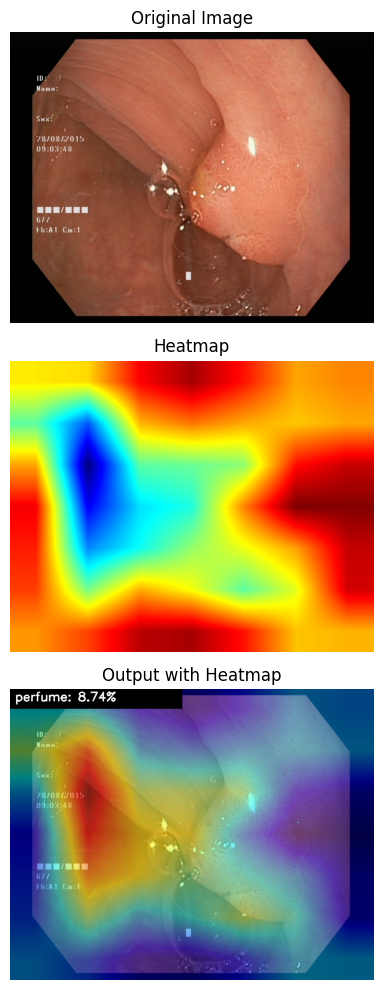

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/2_polyps/test_polyps_ (10).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/2_polyps/test_polyps_ (10).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
[INFO] butternut_squash: 9.26%


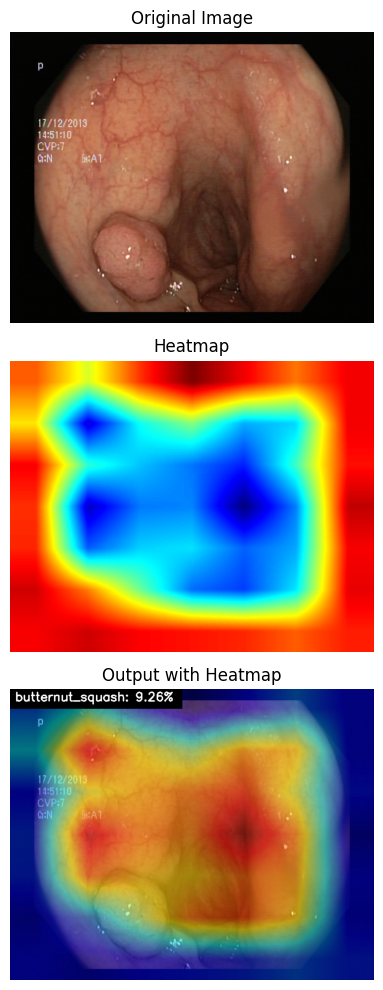

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/2_polyps/test_polyps_ (125).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/2_polyps/test_polyps_ (125).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
[INFO] Band_Aid: 18.19%


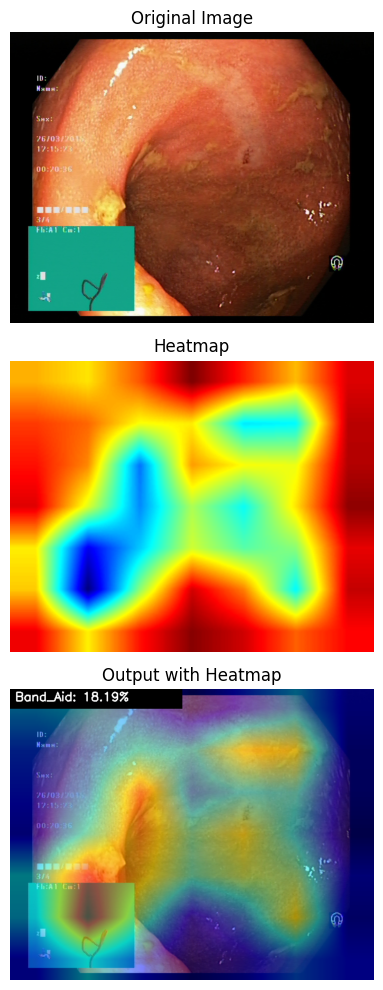

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/1_ulcerative_colitis/test_ulcer_ (106).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/1_ulcerative_colitis/test_ulcer_ (106).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
[INFO] rotisserie: 23.04%


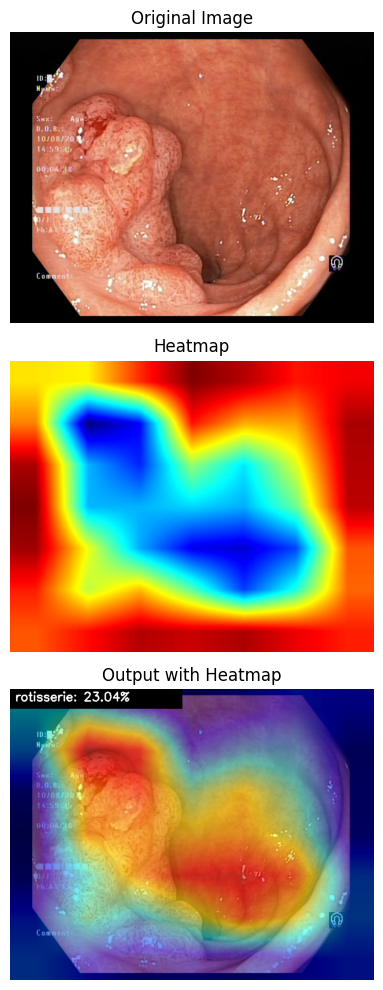

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/2_polyps/test_polyps_ (116).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/2_polyps/test_polyps_ (116).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
[INFO] mask: 55.61%


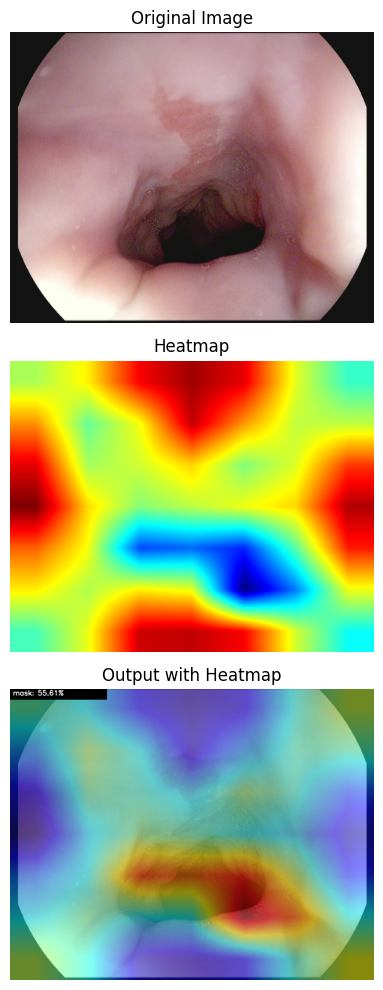

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/3_esophagitis/test_esophagitis_ (113).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/3_esophagitis/test_esophagitis_ (113).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
[INFO] mask: 46.31%


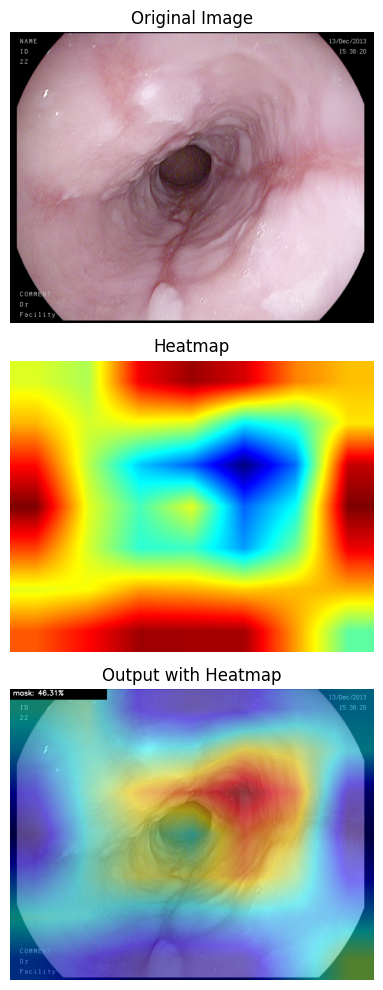

In [ ]:
# Import necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained CNN from disk
model = VGG16(weights="imagenet")

# Load the original image from disk (in OpenCV format) and then resize the image to its target dimensions
orig = cv2.imread("/kaggle/input/gastric/test/3_esophagitis/test_esophagitis_ (120).jpg")
resized = cv2.resize(orig, (224, 224))

# Load the input image from disk (in Keras/TensorFlow format) and preprocess it
image = load_img("/kaggle/input/gastric/test/3_esophagitis/test_esophagitis_ (120).jpg", target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# Use the network to make predictions on the input image and find the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])

# Decode the ImageNet predictions to obtain the human-readable label
decoded = imagenet_utils.decode_predictions(preds)
(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # Store the model, the class index used to measure the class activation map, and the layer to be used when visualizing the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If the layer name is None, attempt to automatically find the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Attempt to find the final convolutional layer in the network by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # Check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # Otherwise, we could not find a 4D layer so the GradCAM algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Construct our gradient model
        gradModel = Model(inputs=self.model.inputs,
                          outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # The convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Compute the average of the gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap such that all values lie in the range [0, 1], scale the resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # Return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # Return a 2-tuple of the color mapped heatmap and the output, overlaid image
        return (heatmap, output)

# Initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

# Resize the resulting heatmap to the original input image dimensions
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

# Display the original image, heatmap, and output image using Matplotlib
plt.figure(figsize=(10, 10))

# Display original image
plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display heatmap
plt.subplot(3, 1, 2)
plt.title("Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

# Display output image with overlay
plt.subplot(3, 1, 3)
plt.title("Output with Heatmap")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()
